In [2]:
import numpy as np
from scipy.linalg import eigh

import matplotlib.pyplot as plt

import pennylane as qml

import torch
import torch.optim as optim

In [3]:
def QAOA_PQC(device: str, nq: int, n_layers: int, shots: int):
    # Define a device
    dev = qml.device(device, wires=nq, shots=shots)
    
    # Define the quantum function
    @qml.qnode(dev, interface='torch')
    def circuit(weights, hamiltonian: str):
        # Apply Hadamard gate on every qubit
        
        for q in range(nq):
            qml.Hadamard(wires=q)
            
        for i in range(n_layers):
         # Apply CNOT gate on the 1st layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
        # Apply Z-rotation gate to the 2nd layer
            for q in range(nq // 2):
                qml.RZ(weights[q], wires=2 * q + 1)
        
        # Apply CNOT gate on the 3rd layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
            # Apply CNOT gate on the 4th layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
            # Apply Z-rotation gate on the 5th layer
            for q in range(nq // 2):
                qml.RZ(weights[nq//2+q], wires=2 * (q + 1))
        
            # Apply CNOT gate on the 6th layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
        # Apply X-rotation gate on every qubit
        for q in range(nq):
            qml.RX(weights[nq-1+q], wires=q)
            
        for i, char in enumerate(hamiltonian):
            if char == 'X':
                qml.Hadamard(wires=i)
            
            if char == 'Y':
                qml.RX(-np.pi/2, wires=i)
                
        return qml.probs()
    
    return circuit

In [4]:
def circ5_PQC(device: str, nq: int, n_layers: int, shots: int):
    # Define a device
    dev = qml.device(device, wires=nq, shots=shots)
    
    # Define the quantum function
    @qml.qnode(dev, interface='torch')
    def circuit(weights, hamiltonian: str):
        
        for i in range(n_layers):
            # Apply RX and RZ gates to the 1st layer
            for q in range(nq):
                qml.RX(weights[i, q, 0], wires=q)
                qml.RZ(weights[i, q, 1], wires=q)
                
            # CNOT gates layers
            for layer in range(nq):
                for j in range(nq):
                    if j != layer:
                        qml.CNOT(wires=[layer, j])
                        
        for q in range(nq):
            qml.RX(weights[n_layers, q, 0], wires=q)
            qml.RZ(weights[n_layers, q, 1], wires=q)
                
        for i, char in enumerate(hamiltonian):
            if char == 'X':
                qml.Hadamard(wires=i)
            elif char == 'Y':
                qml.RX(-np.pi/2, wires=i)
                
        return qml.probs()
    
    return circuit

In [5]:
# Define the cost function
def cost(pqc, nq, weights):
    probs = pqc(weights, 'Z' * nq)
    target_probs = torch.zeros(2**nq)
    target_probs[0] = 0.5  # Probability of |00000>
    target_probs[-1] = 0.5  # Probability of |11111>
    return torch.sum((probs - target_probs) ** 2)


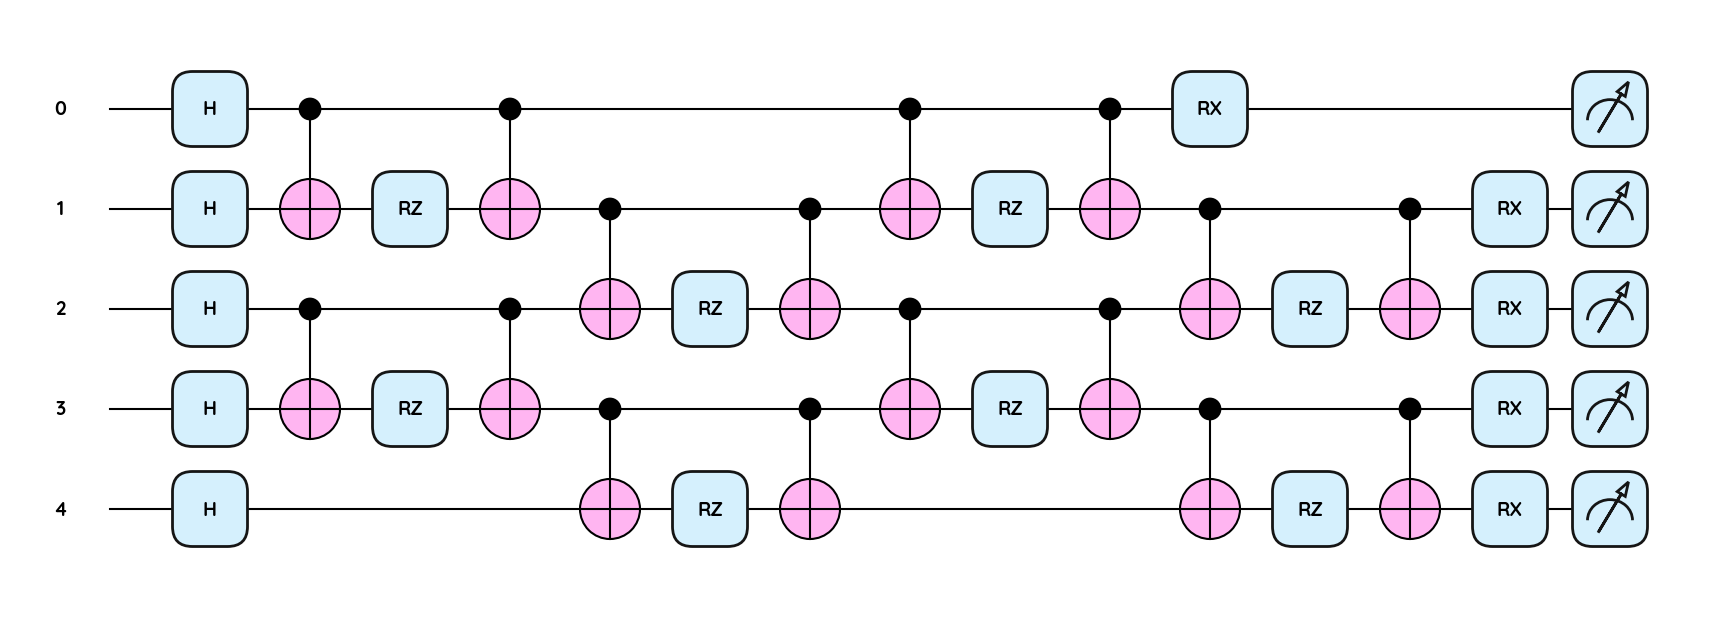

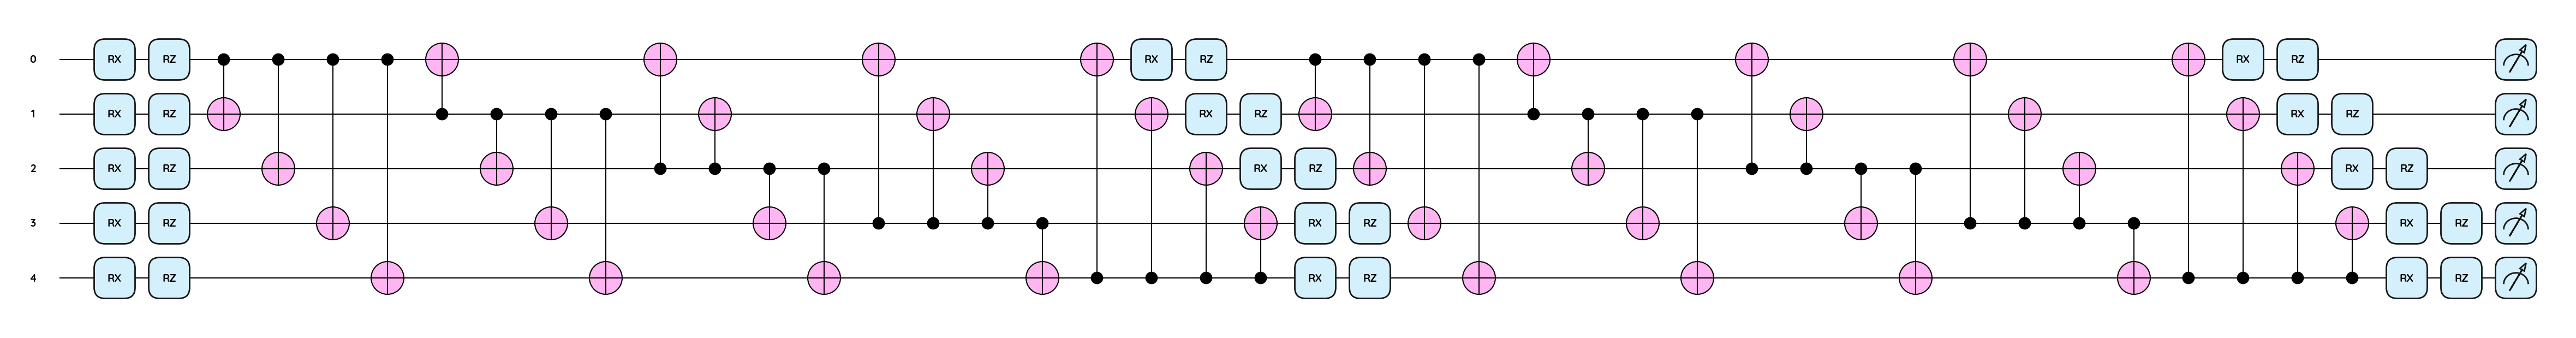

In [6]:
# Parameters
nq = 5
n_layers = 2
shots = 30000
device = 'default.qubit'
torch.manual_seed(42)

QAOA_ansatz = QAOA_PQC(device, nq, n_layers, shots)
circ5_ansatz = circ5_PQC(device, nq, n_layers, shots)

QAOA_weights = torch.zeros(nq*n_layers-1, requires_grad=True)
circ5_weights = weights = torch.zeros((n_layers + 1, nq, 2), requires_grad=True)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(QAOA_ansatz)(QAOA_weights, 'Z' * nq)
plt.show()

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(circ5_ansatz)(circ5_weights, 'Z' * nq)
plt.show()

##### QAOA Ansatz Expressibility of 50% |00000> and 50% |11111>

In [7]:
# Optimizer
optimizer = optim.Adam([QAOA_weights], lr=0.005)

# Training loop
n_iterations = 500
for i in range(n_iterations):
    optimizer.zero_grad()
    loss = cost(QAOA_ansatz, nq, QAOA_weights)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(f"Iteration {i}: Cost = {loss.item()}")

# Output final probabilities
QAOA_final_probs = QAOA_ansatz(QAOA_weights, 'Z' * nq).detach().numpy()
print("Final probabilities:", QAOA_final_probs)

# Print probabilities for |00000> and |11111>
print(f"Probability of |00000>: {QAOA_final_probs[0]:.4f}")
print(f"Probability of |11111>: {QAOA_final_probs[-1]:.4f}")

Iteration 0: Cost = 0.46828615333333334
Iteration 50: Cost = 0.4078659333333333
Iteration 100: Cost = 0.2701670244444444
Iteration 150: Cost = 0.22869094222222225
Iteration 200: Cost = 0.20752770000000004
Iteration 250: Cost = 0.20291927999999998
Iteration 300: Cost = 0.19605237111111115
Iteration 350: Cost = 0.19211920222222223
Iteration 400: Cost = 0.18439701777777778
Iteration 450: Cost = 0.1885983288888889
Final probabilities: [2.50600000e-01 3.33333333e-05 1.00000000e-04 1.28066667e-01
 0.00000000e+00 4.66666667e-04 4.33333333e-04 1.22100000e-01
 1.00000000e-04 0.00000000e+00 0.00000000e+00 5.00000000e-04
 7.33333333e-04 0.00000000e+00 0.00000000e+00 1.33333333e-04
 3.33333333e-05 0.00000000e+00 0.00000000e+00 7.33333333e-04
 4.00000000e-04 0.00000000e+00 0.00000000e+00 3.33333333e-05
 1.24633333e-01 4.33333333e-04 6.33333333e-04 0.00000000e+00
 1.24233333e-01 1.33333333e-04 1.66666667e-04 2.45300000e-01]
Probability of |00000>: 0.2506
Probability of |11111>: 0.2453


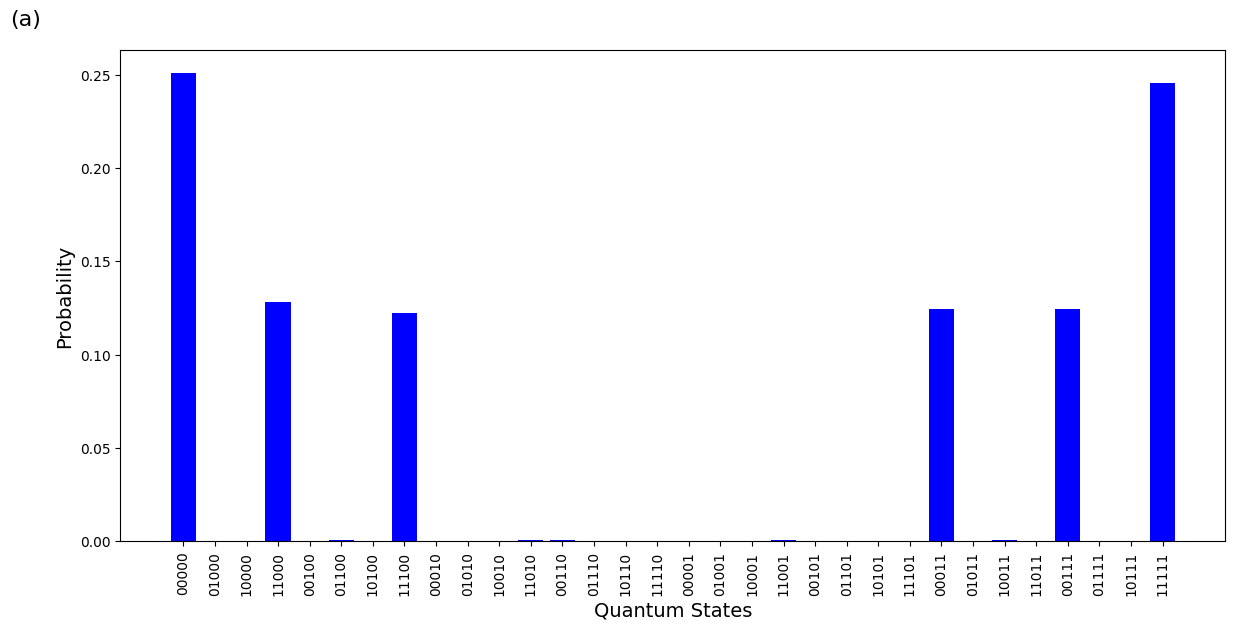

In [16]:
states = [''.join(seq) for seq in np.array(np.meshgrid(*[['0', '1']] * nq)).T.reshape(-1, nq)]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(states, QAOA_final_probs, color='blue')
plt.xlabel('Quantum States', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

# Add an index label (b) in the upper left corner
plt.text(-0.1, 1.05, '(a)', transform=plt.gca().transAxes, fontsize=16)

plt.show()

##### Circ5 Ansatz Expressibility of 50% |00000> and 50% |11111>

In [10]:
# Optimizer
optimizer = optim.Adam([weights], lr=0.005)

# Training loop
n_iterations = 500
for i in range(n_iterations):
    optimizer.zero_grad()
    loss = cost(circ5_ansatz, nq, weights)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(f"Iteration {i}: Cost = {loss.item()}")

# Output final probabilities
circ5_final_probs = circ5_ansatz(circ5_weights, 'Z' * nq).detach().numpy()
print("Final probabilities:", circ5_final_probs)

# Print probabilities for |00000> and |11111>
print(f"Probability of |00000>: {circ5_final_probs[0]:.4f}")
print(f"Probability of |11111>: {circ5_final_probs[-1]:.4f}")

Iteration 0: Cost = 0.5
Iteration 50: Cost = 0.22920324222222221
Iteration 100: Cost = 0.08168853555555555
Iteration 150: Cost = 0.0013366644444444454
Iteration 200: Cost = 0.00022402666666666678
Iteration 250: Cost = 0.00011598000000000051
Iteration 300: Cost = 0.00010122
Iteration 350: Cost = 3.256888888888886e-05
Iteration 400: Cost = 2.5975555555555452e-05
Iteration 450: Cost = 1.7535555555555655e-05
Final probabilities: [5.01700000e-01 4.00000000e-04 3.33333333e-04 0.00000000e+00
 1.33333333e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.66666667e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e-04
 5.00000000e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.33333333e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.33333333e-04
 0.00000000e+00 4.66666667e-04 2.66666667e-04 4.94466667e-01]
Probability of |00000>: 0.5017
Probability of |11111>: 0.4945


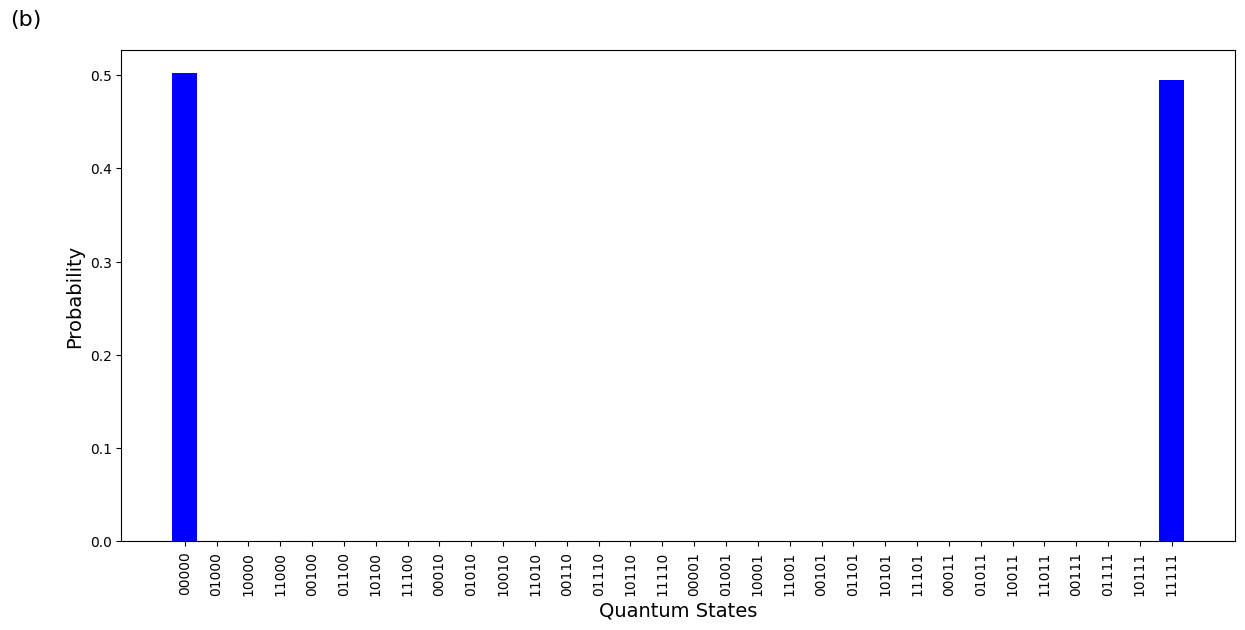

In [14]:
states = [''.join(seq) for seq in np.array(np.meshgrid(*[['0', '1']] * nq)).T.reshape(-1, nq)]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(states, circ5_final_probs, color='blue')
plt.xlabel('Quantum States', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

# Add an index label (b) in the upper left corner
plt.text(-0.1, 1.05, '(b)', transform=plt.gca().transAxes, fontsize=16)

plt.show()